In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [3]:
data = pd.read_csv('data.csv', delimiter=',', encoding='ISO-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


Information of the columns in a data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137839 entries, 0 to 137838
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    137839 non-null  object 
 1   StockCode    137839 non-null  object 
 2   Description  137408 non-null  object 
 3   Quantity     137838 non-null  float64
 4   InvoiceDate  137838 non-null  object 
 5   UnitPrice    137838 non-null  float64
 6   CustomerID   94102 non-null   float64
 7   Country      137838 non-null  object 
dtypes: float64(3), object(5)
memory usage: 8.4+ MB


In [5]:
# data.describe().T
data.describe()

,Quantity,UnitPrice,CustomerID
count,137838.000000,137838.000000,94102.000000
mean,8.943695,5.180769,15292.544048
std,288.015005,106.172683,1739.318647
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13869.000000
50%,3.000000,2.460000,15192.000000
75%,10.000000,4.210000,16889.000000
max,74215.000000,16888.020000,18283.000000


checking for null values

In [6]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,431
Quantity,1
InvoiceDate,1
UnitPrice,1
CustomerID,43737
Country,1


In [7]:
data.shape

(137839, 8)

Delete all the missing records

In [8]:
data.dropna(inplace=True)

In [9]:
print(f'total rows after missing value removal{data.shape}')

total rows after missing value removal(94102, 8)


Handling negative values

In [10]:
data = data[data['Quantity'] > 0]
data[data['UnitPrice']<0].shape[0]

0

In [11]:
data.drop(data[data['Quantity'] < 0].index, inplace=True)

/tmp/ipython-input-11-2690851687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(data[data['Quantity'] < 0].index, inplace=True)


In [12]:
data.shape

(91788, 8)

Calculation of total amount

In [13]:
data['Sales'] = data['Quantity'] * data['UnitPrice']
new_data = data.groupby('CustomerID')['Sales'].sum().reset_index()
new_data

,CustomerID,Sales
0,12346.0,77183.60
1,12347.0,1187.18
2,12348.0,1120.24
3,12350.0,334.40
4,12352.0,1561.81
...,...,...
2088,18269.0,168.60
2089,18270.0,111.95
2090,18273.0,51.00
2091,18280.0,180.60


calculating the number of transactions of each customer

In [14]:
num_trans = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()
num_trans

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,60
2,12348.0,23
3,12350.0,17
4,12352.0,38
...,...,...
2088,18269.0,7
2089,18270.0,5
2090,18273.0,1
2091,18280.0,10


In [15]:
#Converting 'InvoiceDate' to DateTime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
#Calculating 'Last Transaction' Days:
data['Last Transaction'] = (data['InvoiceDate'].max() - data['InvoiceDate']).dt.days
#Grouping by 'CustomerID' and 'Country' and Calculating Maximum 'Last Transaction'
lt = data.groupby(['CustomerID', 'Country'])['Last Transaction'].max().reset_index()
#Merging with Number of Transactions
merge_table = pd.merge(lt, num_trans, how='inner', on='CustomerID')
new_df = pd.merge(merge_table, new_data, how='inner', on='CustomerID')
print(lt)
print(new_df)

      CustomerID         Country  Last Transaction
0        12346.0  United Kingdom                70
1        12347.0         Iceland               111
2        12348.0         Finland               102
3        12350.0          Norway                54
4        12352.0          Norway                41
...          ...             ...               ...
2090     18269.0  United Kingdom               110
2091     18270.0  United Kingdom                11
2092     18273.0  United Kingdom                 2
2093     18280.0  United Kingdom                22
2094     18283.0  United Kingdom                81

[2095 rows x 3 columns]
      CustomerID         Country  Last Transaction  InvoiceNo     Sales
0        12346.0  United Kingdom                70          1  77183.60
1        12347.0         Iceland               111         60   1187.18
2        12348.0         Finland               102         23   1120.24
3        12350.0          Norway                54         17    334.40
4  

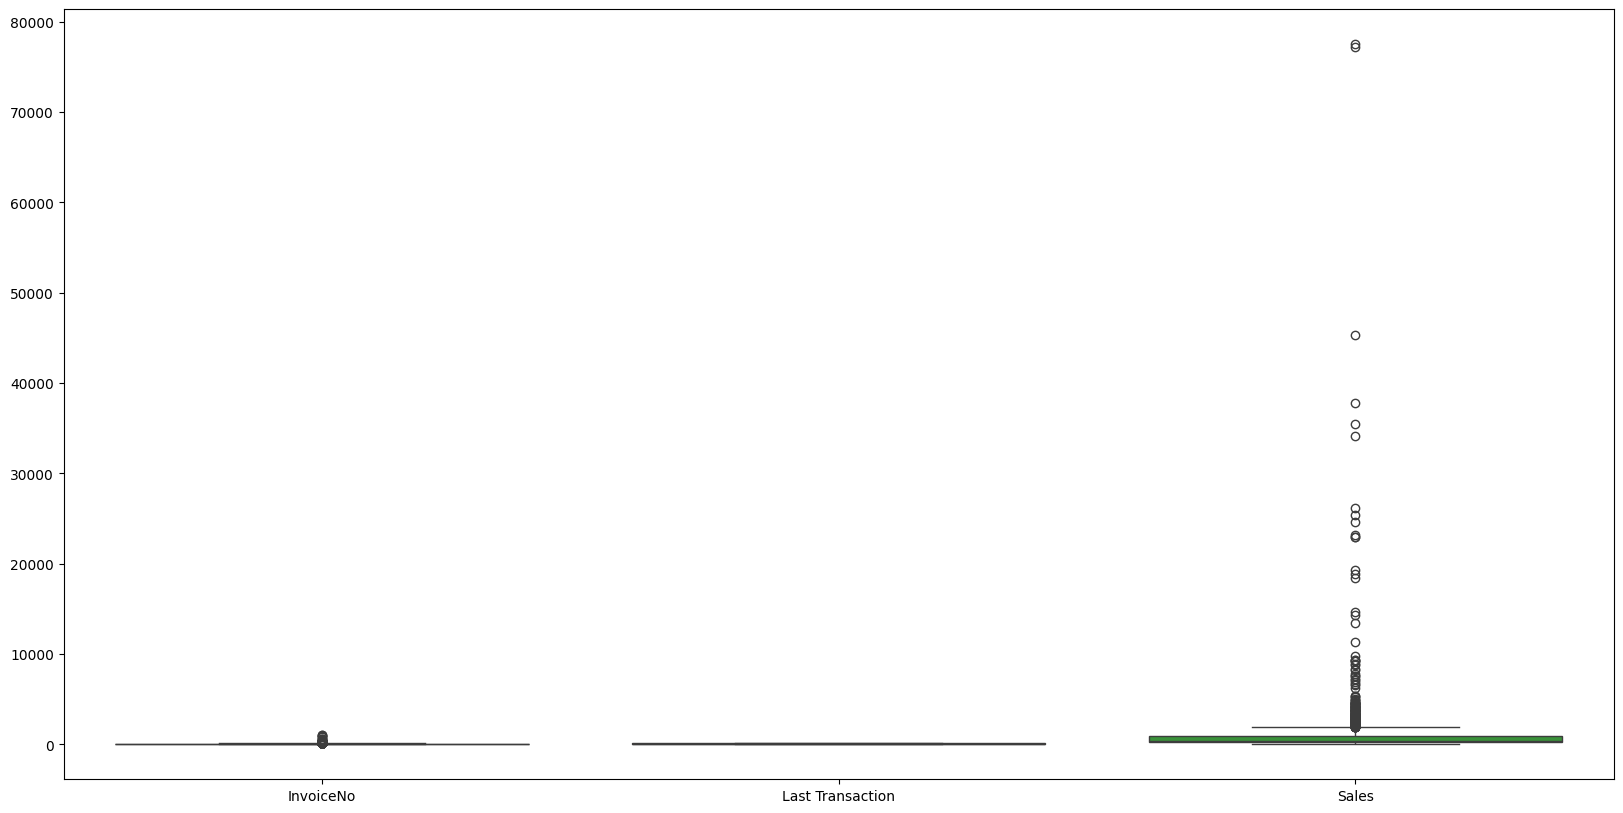

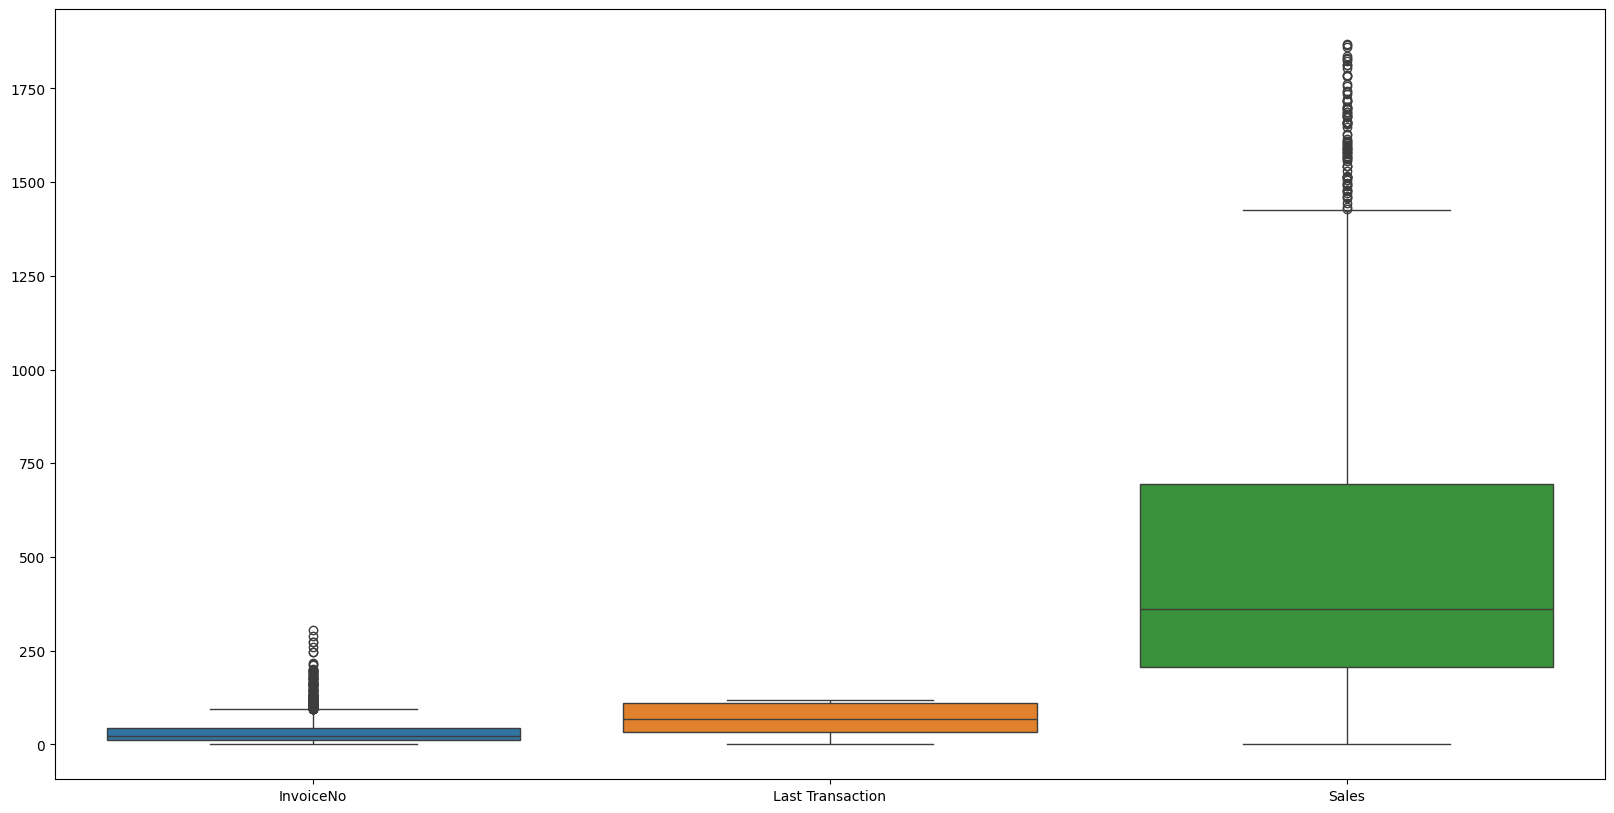

In [16]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=new_df[['InvoiceNo', 'Last Transaction', 'Sales']])
plt.show()

IQR = new_df['Sales'].quantile(0.75) - new_df['Sales'].quantile(0.25)
lower_limit = new_df['Sales'].quantile(0.25) - 1.5 * IQR
upper_limit = new_df['Sales'].quantile(0.75) + 1.5 * IQR
new_df_iqr = new_df[(new_df['Sales'] < upper_limit) & (new_df['Sales'] > lower_limit)]

plt.figure(figsize=(20, 10))
sns.boxplot(data=new_df_iqr[['InvoiceNo', 'Last Transaction', 'Sales']])
plt.show()

new_df_iqr.reset_index(drop=True, inplace=True)

In [17]:
from sklearn.preprocessing import MinMaxScaler
new2_df= new_df_iqr[['Last Transaction','InvoiceNo','Sales']]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(new2_df)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = ['Last Transaction','InvoiceNo','Sales']
scaled_df['Country'] = new_df_iqr['Country']
scaled_df


,Last Transaction,InvoiceNo,Sales,Country
0,0.940678,0.194719,0.635441,Iceland
1,0.864407,0.072607,0.599585,Finland
2,0.457627,0.052805,0.178661,Norway
3,0.347458,0.122112,0.836106,Norway
4,0.262712,0.029703,0.101262,Belgium
...,...,...,...,...
1901,0.932203,0.019802,0.089853,United Kingdom
1902,0.093220,0.013201,0.059509,United Kingdom
1903,0.016949,0.000000,0.026862,United Kingdom
1904,0.186441,0.029703,0.096281,United Kingdom


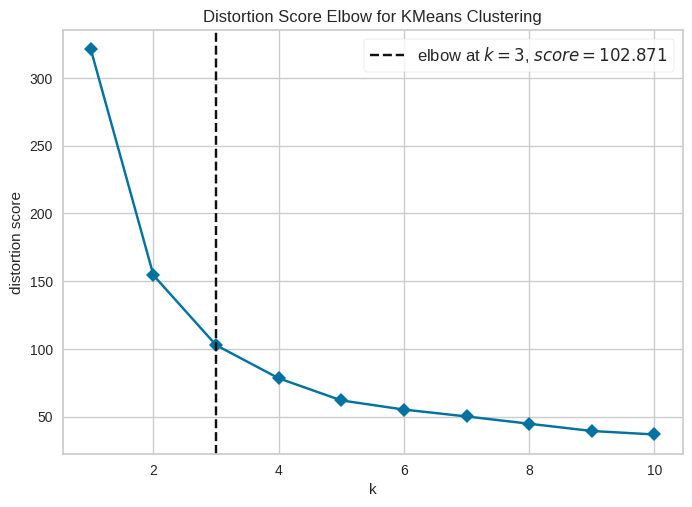

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
df_k=scaled_df.drop(columns=['Country'],axis=1)
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_k)        # Fit data to visualizer
visualizer.show()

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = silhouette_score(df_k, model.labels_, metric='euclidean')
print(score)

from sklearn.cluster import AgglomerativeClustering
hierarchial = AgglomerativeClustering(n_clusters=3)
y_predicted_hierarchial = hierarchial.fit_predict(df_k)
df_k['clusters_hierarchial']= y_predicted_hierarchial
df_k.head(30)

0.34382516270347196


,Last Transaction,InvoiceNo,Sales,clusters_hierarchial
0,0.940678,0.194719,0.635441,2
1,0.864407,0.072607,0.599585,2
2,0.457627,0.052805,0.178661,0
3,0.347458,0.122112,0.836106,0
4,0.262712,0.029703,0.101262,0
5,0.338983,0.085809,0.256168,0
6,0.296610,0.069307,0.343091,0
7,0.347458,0.062706,0.213381,0
8,0.474576,0.042904,0.194838,0
9,0.838983,0.250825,0.871624,2


In [20]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df_k)
df_k['clusters'] = y_predicted


Calculating the silhouette score

In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = silhouette_score(df_k, km.labels_, metric='euclidean')
print(score)

0.7970794900856828


Hierarchical clustering

In [24]:
from sklearn.cluster import AgglomerativeClustering
hierarchical = AgglomerativeClustering(n_clusters=2)
y_predicted_hierarchial = hierarchial.fit_predict(df_k)
df_k['clusters_hierarchical'] = y_predicted_hierarchial
df_k

,Last Transaction,InvoiceNo,Sales,clusters_hierarchial,clusters,clusters_hierarchical
0,0.940678,0.194719,0.635441,2,2,2
1,0.864407,0.072607,0.599585,2,2,2
2,0.457627,0.052805,0.178661,0,0,0
3,0.347458,0.122112,0.836106,0,0,0
4,0.262712,0.029703,0.101262,0,0,0
...,...,...,...,...,...,...
1901,0.932203,0.019802,0.089853,1,1,1
1902,0.093220,0.013201,0.059509,0,0,0
1903,0.016949,0.000000,0.026862,0,0,0
1904,0.186441,0.029703,0.096281,0,0,0


calculating silhouette score for agglomerative clustering

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = silhouette_score(df_k, km.labels_, metric='euclidean')
print(score)

0.8295254910850066
